In [1]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from skimage import io, img_as_ubyte
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing as preproc
import py_pcha
from sklearn.neighbors import KNeighborsClassifier
import random


import seaborn as sns

In [2]:
# Globals
_SEED = 0

In [3]:
# Set the paths for image files, labels etc
faces_path = "../data/Faces/"
labels_path = "../data/labels.csv"
names_path = "../data/filenames.txt"

In [4]:
# Read labels as pandas object from labels.csv
labels_columns = ['age', 'gender', 'race']
labels = pd.read_csv(labels_path)
labels = pd.DataFrame(data=labels.values, columns=labels_columns)

In [5]:
# filter labels
def filter_by_age(df, fromAge, toAge):
    return df[(df.age >= fromAge) & (df.age <=toAge)]

In [6]:
filtered_labels = filter_by_age(labels, 15, 18)

In [7]:
# Open a random image to get dimensions
test_img_name = 0
test_img = io.imread(faces_path+f"{test_img_name}.jpg", as_gray=True)
h, w = test_img.shape
del test_img

In [8]:
X = np.empty((len(filtered_labels), h*w))

for i, index in enumerate(filtered_labels.index):
    print(i,index)
    a = io.imread(faces_path+f"{index}.jpg", as_gray=True)
    a = img_as_ubyte(a)
    X[i, :] = a.reshape(1, -1)
    
del a
print('Done loading images')

0 620
1 621
2 622
3 623
4 624
5 625
6 626
7 627
8 628
9 629
10 630
11 631
12 632
13 633
14 634
15 635
16 636
17 637
18 638
19 639
20 640
21 641
22 642
23 643
24 644
25 645
26 646
27 647
28 648
29 649
30 650
31 651
32 652
33 653
34 654
35 655
36 656
37 657
38 658
39 659
40 660
41 661
42 662
43 663
44 664
45 665
46 666
47 667
48 668
49 669
50 670
51 671
52 672
53 673
54 674
55 675
56 676
57 677
58 678
59 679
60 680
61 681
62 682
63 683
64 684
65 685
66 686
67 687
68 688
69 689
70 690
71 691
72 692
73 693
74 694
75 695
76 696
77 697
78 698
79 699
80 700
81 701
82 702
83 703
84 704
85 705
86 706
87 707
88 708
89 709
90 710
91 711
92 712
93 713
94 714
95 715
96 716
97 717
98 718
99 719
100 720
101 721
102 722
103 723
104 724
105 725
106 726
107 727
108 728
109 729
110 730
111 731
112 732
113 733
114 734
115 735
116 736
117 737
118 738
119 739
120 740
121 741
122 742
123 743
124 744
125 745
126 746
127 747
128 748
129 749
130 750
131 751
132 752
133 753
134 754
135 755
136 756
137 757
138 75

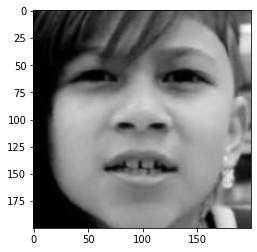

In [9]:
plt.imshow((X[0,:]).reshape(h,w), cmap='gray')

In [16]:
n_components = 7 # num components
k = 5 # number of nearest neighbours
knn = KNeighborsClassifier(n_neighbors=k)

In [11]:
y = filtered_labels["race"]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.25, random_state=42, shuffle=True)


In [12]:
n, p = np.shape(Xtrain)
p

40000

In [18]:
#Archetypal analysis
# Does not require that you center data
XC, S, C, SSE, varexpl = py_pcha.PCHA(Xtrain.T, noc=n_components, delta=0.1)
X_hat = Xtrain.T @ C @ S
L = 0.5*np.linalg.norm(Xtrain.T-X_hat)**2
components = XC.T

knn.fit(S.T,ytrain)
Xtest_transform = np.linalg.lstsq(XC, Xtest.T)[0] #solve Xtest = XC @ S for S
acc = knn.score(Xtest_transform.T,ytest)
X_test_hat = (XC @ Xtest_transform).T

C:\Users\pf259\AppData\Local\Temp/ipykernel_19640/2263908163.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Xtest_transform = np.linalg.lstsq(XC, Xtest.T)[0] #solve Xtest = XC @ S for S


In [19]:
#Helper functions
n_rows = 7 #for plotting
n_cols = 7 #for plotting

left = 0.0
right = 0.0
bottom = 0.99
top = 0.83
wspace = 0.0
hspace = 0.0
image_shape = (h, w)
# Function for plotting images
def plot_components(title, components):
    plt.figure(figsize=(2. * n_cols, 2.26 * n_rows))
    plt.suptitle(title, size=24)
    # For each of the first 6 observations plot
    start_index = random.randint(0, n)
    for i, comp in enumerate(components):
        plt.subplot(n_rows, n_cols, i + 1)
        # normalize colormap
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        # Remove ticks from plot
        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)
    
def plot_recons(X, title, Nplot=100):
    plt.figure(figsize=(2. * 10, 2.26 * 10))
    plt.suptitle(title, size=24)
    # For each of the first 6 observations plot
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        # normalize colormap
        idx = random.randint(0, 210)
        comp = X[idx,:]
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        # Remove ticks from plot
        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)

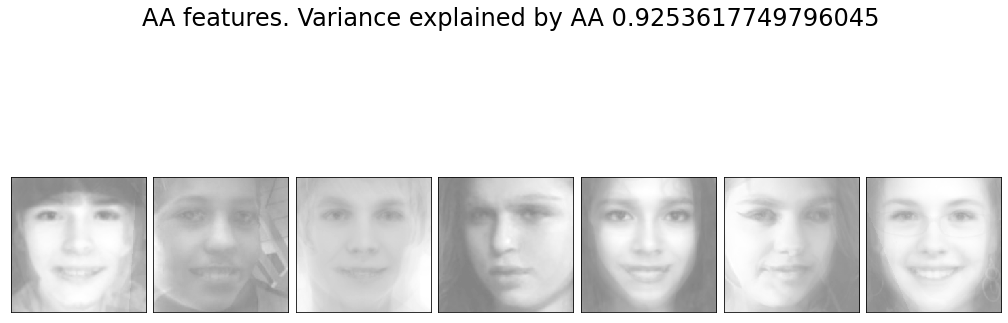

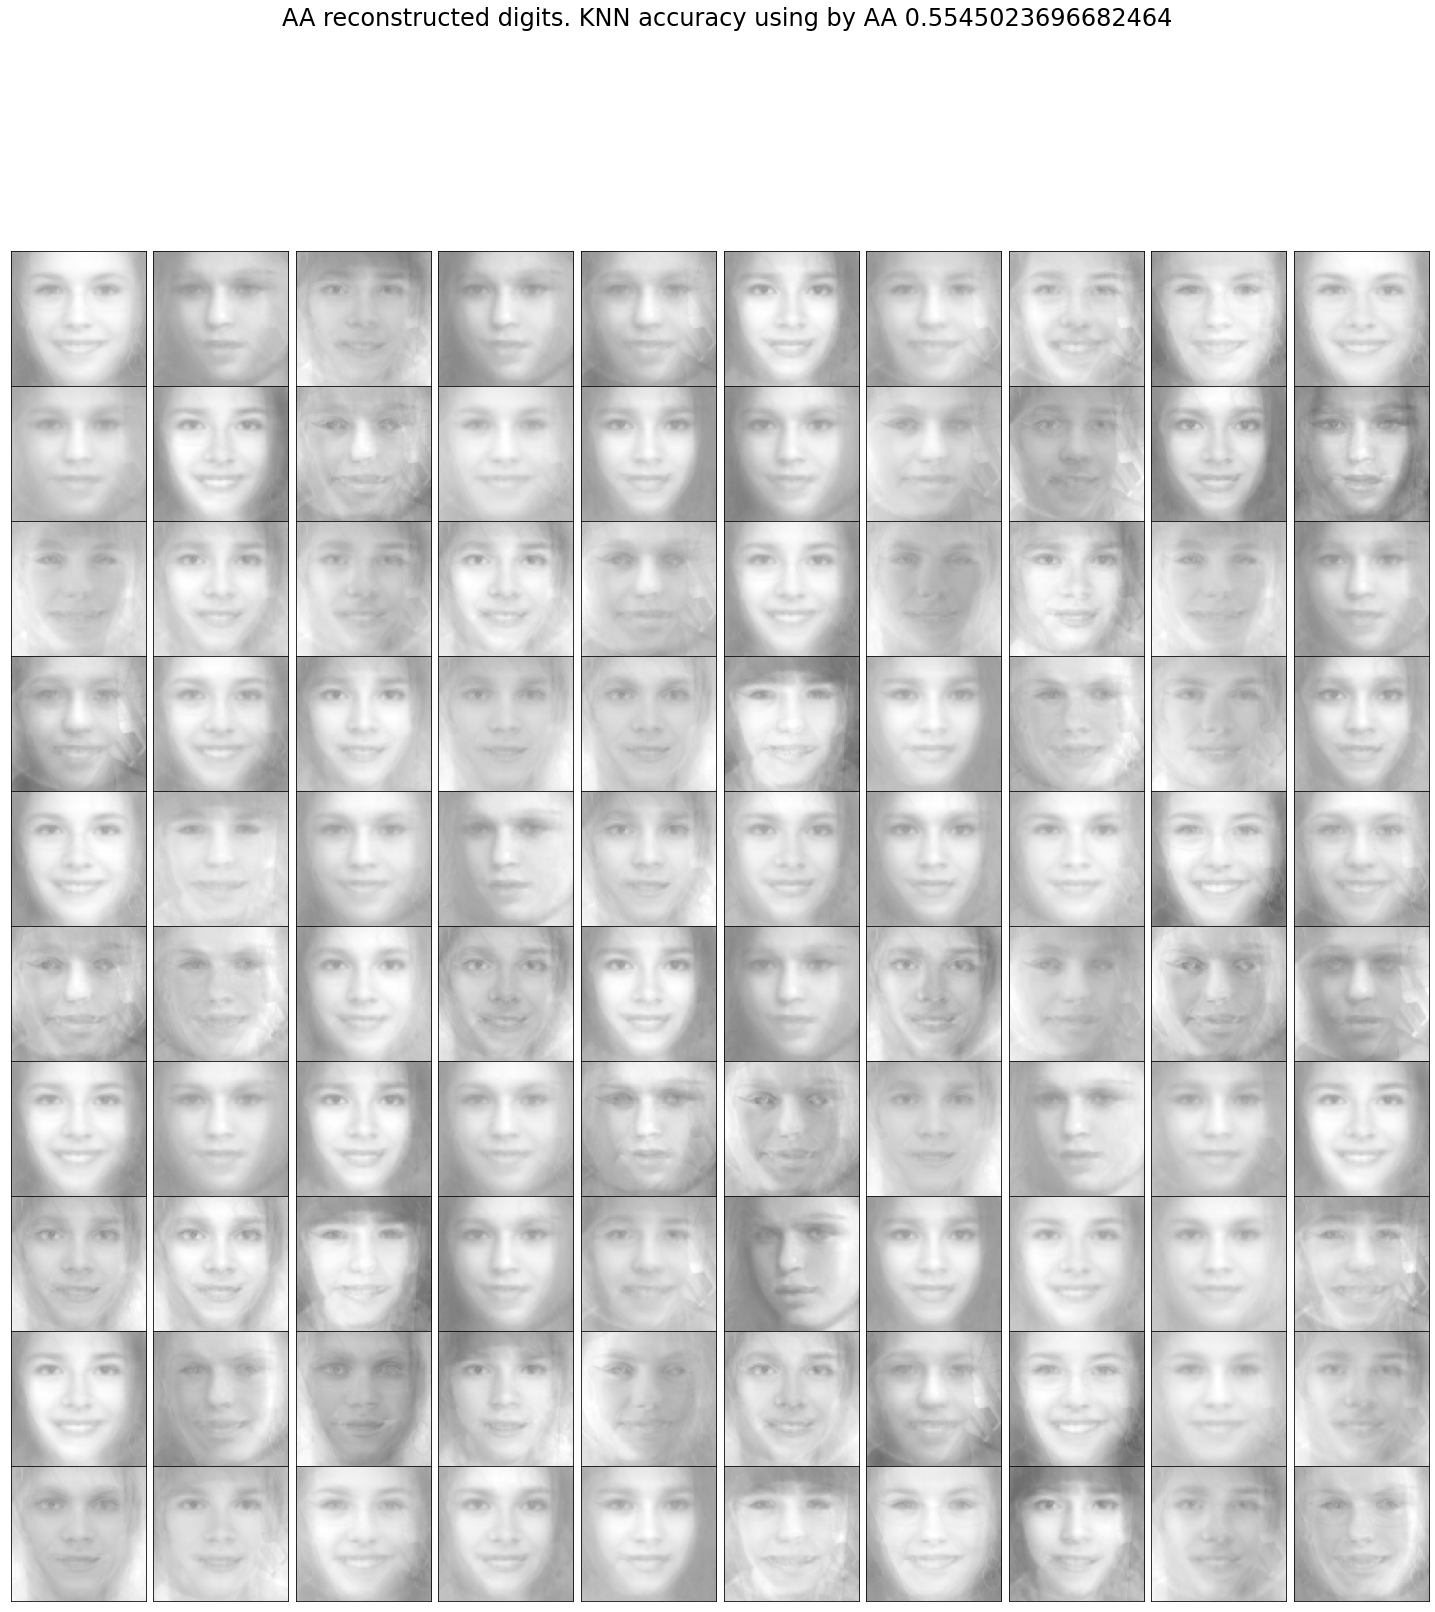

In [20]:
method = "AA"
SST = np.sum(np.sum(Xtrain**2))

plot_components(f'{method} features. Variance explained by {method} {1-2*L/SST}', components)
plot_recons(X_test_hat, f'{method} reconstructed digits. KNN accuracy using by {method} {acc}')